# Import necessary modules

In [60]:
import requests
from bs4 import BeautifulSoup
import warnings
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Scraping

In [176]:
# Create an empty list for the job cardss
job_cards = []

# The site provide only a certain  part of the matched jobs at once
# so we have to iterate over the pages one-by-one to gain all the job cards
for page_number in range(1, 300):
    url = f"https://www.profession.hu/en/advertisements/budapest/{page_number},0,23"
    page = requests.get(url, verify=False)
    soup = BeautifulSoup(page.text, "html.parser")
    job_cards.extend(soup.find_all("li", class_="job-card"))

In [177]:
# Create an empty Pandas dataframe for the jobs
df_jobs_raw = pd.DataFrame()

# Iterate through the list of job cards,
# and extract job data from the list job_cards into the df_jobs_raw dataframe
for job in job_cards:
    
    # Job cards contain different number of so-called job card tags.
    # Firstly we extract them into a list so that later we can insert them into the dataframe
    job_tags = job.find_all("span", class_="job-card__tag")
    
    # Create the job item extracting job data from the job object
    job_item = {
        "affiliation" : job.get("data-affiliation"),
        "item-name" : job.get("data-item-name"),
        "application_type" : job.get("data-application_type"),
        "category1" : job.get("data-category1"),
        "category2" : job.get("data-category2"),
        "category3" : job.get("data-category3"),
        "category4" : job.get("data-category4"),
        "category5" : job.get("data-category5"),
        "category6" : job.get("data-category6"),
        "currency" : job.get("data-currency"),
        "item-brand" : job.get("data-item-brand"),
        "item-id" : job.get("data-item-id"),
        "item-name" : job.get("data-item-name"),
        "link" : job.get("data-link"),
        "linktarget" : job.get("data-linktarget"),
        "list-id" : job.get("data-list-id"),
        "list-index" : job.get("data-list-index"),
        "list-name" : job.get("data-list-name"),
        "location-id" : job.get("data-location-id"),
        "price" : job.get("data-price"),
        "prof-category" : job.get("data-prof-category"),
        "prof-id" : job.get("data-prof-id"),
        "prof-name" : job.get("data-prof-name"),
        "prof-position" : job.get("data-prof-position"),
        "prof_product_name" : job.get("data-prof_product_name"),
        "quantity" : job.get("data-quantity"),
        "row-number" : job.get("data-row-number"),
        "value" : job.get("data-value"),
        "variant" : job.get("data-variant"),
        "id" : job.get("id"),
        # Previously created job tags are extracted end stored in this step.
        # The string elements of the list are preprocessed so that they don't contain
        # whitespaces and their text let be lowercase in order to be more comparable
        "job_tags" : [job_tags[i].text.replace(" ", "").strip().lower() for i in range(len(job_tags))]
    }
    # Append a new job_item row to the dataframe
    df_jobs_raw = pd.concat([df_jobs_raw, pd.DataFrame([job_item])], ignore_index=True)

In [189]:
# From job_tags we extract salary information.
# Extract all the first list items that contains "huf" substring
df_jobs_raw["salary"] = df_jobs_raw["job_tags"].apply(lambda tags: next((tag for tag in tags if  "huf" in tag.lower()), None))

# From job_tags we extract expected language skill information.
# Extract all the first list items that contains language-level related substrings
keywords = ["-basic", "-intermediate", "-higher", "-native"]
df_jobs_raw["language_skill"] = df_jobs_raw["job_tags"].apply(lambda tags: next(
        (
            tag for tag in tags if any(keyword in tag.lower() for keyword in keywords)
        ), None
    )
)
df_jobs_raw.index.name = "index"

# For time saving reasons save the raw database so that later
# we don't have to query the content from the webpage again.
df_jobs_raw.to_csv("df_jobs_raw.csv")

# Cleaning

In [10]:
# Load the previously saved file for cleaning
df_jobs = pd.read_csv("df_jobs_raw.csv", index_col="index")

# "price" and "value" columns can be dropped, because they contains only null values.
# "prof-position", "item-id", "list-id", "list-index", "prof-id", "row-number", "id" columns
#    can be dropped, because they semms to be a kind of index column.
# "item-brand" column can be dropped, because its values are the same as values of "affiliation" column.
# "category5" column can be dropped, because its values are the same as values of "category3" column.
# "currency", "linktarget", "quantity" columns can be dropped, because they contain only one value in all the rows.
# "link", "list-name" column can be dropped, because it doesn't contain any relevant information
# "category6" column can be dropped, because its values are the same as values of "location-id" column.
# "job_tags" column can be dropped, because all the relevant information were extracted to individual columns.
# "variant" column can be dropped, because it contains redundant information with salary column
# "item-name" column can be dropped, because its values are the same as values of "prof-name" column.
# "prof-category" column can be dropped, because its values are the numeric representation of "category1" column.
columns_to_drop = [
    "price", "value", "prof-position", "item-id", "list-index", "item-brand",
    "category5", "currency", "linktarget", "list-id", "link", "list-name",
    "category6", "quantity", "prof-id", "row-number", "id", "job_tags", "variant",
    "item-name", "prof-category"
]
df_jobs.drop(columns_to_drop, axis=1, inplace=True)

# Rename columns to have more relevant names for their actual values,
# and to have more consequent names
df_jobs.rename(columns={
    "category1":"prof_category_1",
    "category2":"prof_category_2",
    "category3":"employment_type",
    "category4":"expected_experience",
    "location-id":"location",
    "prof-name":"prof_name",
    "prof_product_name":"subscr_product_name"
}, inplace=True)

We have "salary" column but the type of its values is string and the salary itself is embedded into this string in various formats, various time periods and net or gross amount:

- net500k-800khuf/month
- gross1,0m-2,0mhuf/month
- net400khuf/month
- gross1700-3400huf/hour
- net2300-2500huf/hour
- etc...

So we have to extract the salary data itself from these texts.mondtype: int64

In [11]:
def extract_salary_info(text):
    
    # Initialize all salary-related variables to None
    salary_type = salary_currency = salary_period = salary_min = salary_prefix_min = salary_max = salary_prefix_max = None
    
    # Extract salary type (gross or net)
    match_salary_type = re.search(r'(gross|net)', text)
    if match_salary_type:
        salary_type = match_salary_type.group()
    
    # Extract currency (e.g., HUF)    
    match_salary_currency = re.search(r'(huf)', text)
    if match_salary_currency:
        salary_currency = match_salary_currency.group()
    
    # Extract salary period (e.g., per month, hour, or year)
    match_salary_period = re.search(r'(month|hour|year)', text)
    if match_salary_period:
        salary_period = match_salary_period.group()
        
    # Extract minimum salary value (e.g., 1,2 or 300)
    match_salary_min = re.search(r'\d+(,|)\d+', text)
    if match_salary_min:
        salary_min = match_salary_min.group().replace(",", ".")
    
    # Extract prefix for minimum salary (e.g., 'k' for thousand, 'm' for million)
    match_salary_prefix_min = re.search(r'(m|k)(-|h)', text)
    if match_salary_prefix_min:
        salary_prefix_min = match_salary_prefix_min.group(1)
    
    # Extract maximum salary value (e.g., 500 or 1,5)
    match_salary_max = re.search(r'-(\d+)(,|)(\d+)', text)
    if match_salary_max:
        salary_max = "".join(match_salary_max.group(1, 2, 3)).replace(",", ".")
    
    # Extract prefix for maximum salary (e.g., 'k' or 'm' before 'huf')
    match_salary_prefix_max = re.search(r'(m|k)(huf)', text)
    if match_salary_prefix_max and salary_max != None:
        salary_prefix_max = match_salary_prefix_max.group(1)
    
    # Convert salary_min to float and scale based on prefix
    salary_min = float(salary_min) * (1000 if salary_prefix_min == "k" else 1000000 if salary_prefix_min == "m" else 1)
    
    # Convert salary_max to float and scale based on prefix (default to 0 if not found)
    salary_max = float(salary_max or 0) * (1000 if salary_prefix_max == "k" else 1000000 if salary_prefix_max == "m" else 1)
    
    # Calculate average salary (use min if max is not provided)
    average_salary = salary_min if salary_max == 0 else (salary_min + salary_max) / 2

    
    # Normalize salary to gross monthly salary
    # - If yearly, divide by 12
    # - If hourly, multiply by 168 (approx. hours/month)
    # - If net, convert to gross by dividing by 0.66
    gross_monthly_salary =  int((average_salary / 12 if salary_period == "year"
                        else average_salary * 168 if salary_period == "hour"
                        else average_salary) * (1 / 0.66 if salary_type == "net" else 1))
                            
    
    return int(gross_monthly_salary)

# Apply the salary extraction function to the 'salary' column of the DataFrame where 'salary' is not null
df_jobs["gross_monthly_salary"] = df_jobs[df_jobs["salary"].isnull() == False]["salary"].apply(lambda x: pd.Series(extract_salary_info(x)))

In [14]:
# Define lower and upper bounds for salary outliers
lower_bound = 200000
upper_bound = 2000000

# Find outliers
outliers = df_jobs[(df_jobs['gross_monthly_salary'] < lower_bound) | (df_jobs['gross_monthly_salary'] > upper_bound)]

# Delete outliers
df_jobs = df_jobs.drop(outliers.index)
print(f'{len(outliers)} outliers were dropped')

0 outliers were dropped


In 'language_skill' column the nationality and the level of the necessary language skills are concatenated, so we have to extract them into two new column

In [48]:
def extract_language_info(text):

    # Initialize all salary-related variables to None
    language_nationality = language_level = None

    # Extract language_nationality and language_level in one step
    match_language_nationality = re.search(r"([a-zA-Z]+)-([a-zA-Z]+)", text)
    if match_language_nationality:
        language_nationality = match_language_nationality.group(1)
        language_level = match_language_nationality.group(2)

    return language_nationality, language_level

# Apply the language extraction function to the 'language_skill' column of the DataFrame where 'language_skill' is not null
df_jobs[["language_nationality", "language_level"]] = df_jobs[df_jobs["language_skill"].isnull() == False]["language_skill"].apply(lambda x: pd.Series(extract_language_info(x)))

# Exploratory Data Analysis (EDA)

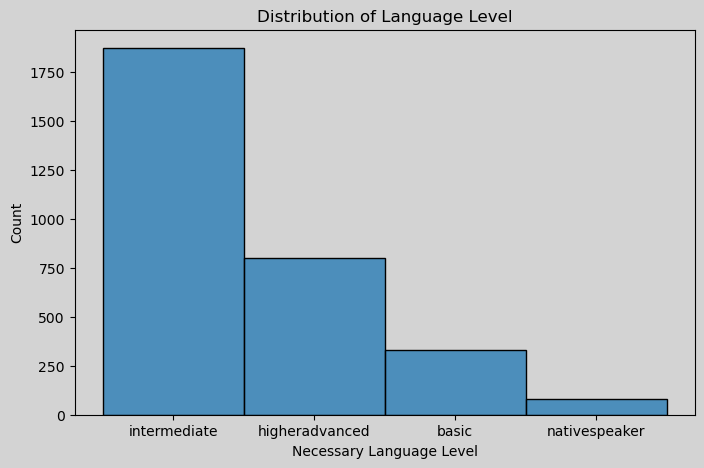

In [75]:
plt.figure(figsize=(8, 5), facecolor="lightgrey")

sns.histplot(
    data=df_jobs,
    x="language_level"
)

ax = plt.gca()  
ax.set_facecolor("lightgrey")

plt.xlabel("Necessary Language Level")
plt.ylabel("Count")
plt.title("Distribution of Language Level")
plt.show()

# As we can see, most of the job need intermediat language level. The difference between the count of lanuage levels is significant.

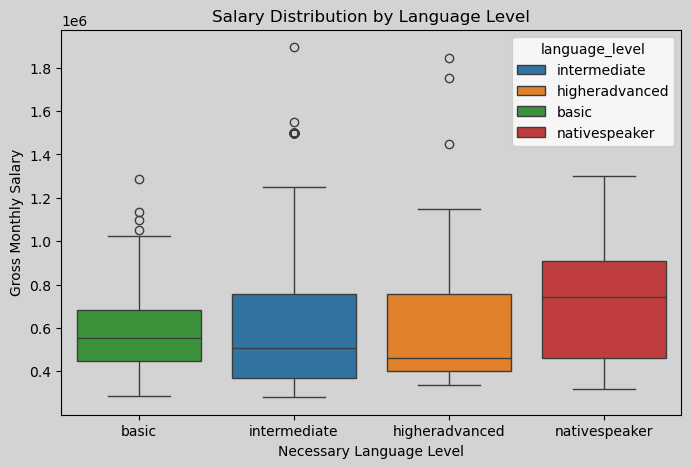

In [74]:
plt.figure(figsize=(8, 5), facecolor="lightgrey")

sns.boxplot(
    data=df_jobs,
    x="language_level",
    order=['basic', 'intermediate', 'higheradvanced', 'nativespeaker'],
    y="gross_monthly_salary",
    hue="language_level"
)

ax = plt.gca()  
ax.set_facecolor("lightgrey")

plt.xlabel("Necessary Language Level")
plt.ylabel("Gross Monthly Salary")
plt.title("Salary Distribution by Language Level")
plt.show()

# Basically we expected more clearly differences between the distributions,
# but as we can see,intermediate and higheradvanced level share quite similar one,
# and although basic and nativespeaker are more different, but not as much as we can expect.
# This suggest that the salary doesn't as depend on the language level as depends on the
# profession or the experience.